# Обработка и анализ признаков

Возьмите датасет вашего варианта из лабораторной работы № 1. Если вы раньше применяли бинаризацию целевого признака, то сейчас этого делать не нужно. Добавьте для тестирования искусственно сгенерированный признак random с рандомными вещественными значениями.

## Корреляции

Нарисуйте матрицу корреляций признаков. Вам поможет код:
```
corr = data.corr()
sns.heatmap(corr)
```
Нарисуйте 4 графика рассеяния: два на осях самых коррелированных пар признаков и два - для некоррелированных пар. Скопируйте их в отчет, разместив рядом друг с другом. Чем коррелированные графики отличаются от некореллированных?

С какими признаками сильнее всего коррелирует целевой?


## Важность признаков

Сравните разные подходы к определению "важных" признаков. Для этого постройте столбцовую диаграмму, в которой по оси х будут отмечены названия признаков. Каждому признаку соответсвует набор столбцов разного цвета, высота которых отражает важность в смысле разных определений. Нормируйте все важности одного типа на максимальную важность этого типа. Если признаков больше 7, разбейте диаграмму на несколько рисунков по 7 признаков в каждом. 

Подходы к определению важности признака f:

* качество предсказания целевого признака моделью ExtraTrees по одному признаку f 

* Свойство feature_importances_ модели ExtraTrees, обученной **на всех признаках** одновременно

* Модуль коэффициента линейной модели (признаки должны быть нормированными!)

* Модуль коэффициента корреляции с целевым признаком

* Количество взаимной информации в f и целевом признаке (используйте mutual_info_regression для задачи регрессии и mutual_info_classif для задачи классификации)

Код для построения столбцовой диаграммы по датафрейму из важностей (см. лаб. работу №1):
```
importance = importance.melt(id_vars=['name'], value_vars=['quality', 'ExtraTrees', 'linear', 'corr', 'MI'])
sns.barplot(x='value', y='name', hue='variable', data=importance)
```

Какой самый важный признак? Какая важность оказалась у признака random?

## Главные компоненты

1) Примените метод главных компонент к нормированной матрице объектов-признаков (sklearn.decomposition.PCA). Спроектируйте датасет на две главные компоненты (fit_transform) и постройте в плоскости этих компонент график рассеяния датасета, используя в качестве цвета значения целевого признака.  

2) Выведите координаты главной компоненты и соответсвующие им названия признаков (свойство components_). Анализируя вывод, выясните какие признаки меняются "в унисон" и соответствует ли это матрице корреляций. 

3) Примените PCA в качестве генеративной модели. Эффектнее всего такая генерация выглядит для датасета с изображениями, но мы попробуем применить аналогичную операцию и для наших данных. Для этого на графике рассеяния выберите какие-нибудь два набора значений главных компонент в областях разных классов (разных значений целевого признака - для регрессии). Причем выберите так, чтобы этим значениям не соответствовала никакая точка из обучающей выборки. После этого примените обратную трансформацию и найдите признаки, соответсвующие этим двум наборам. Запишите в отчете эти два набора в таблицу вместе с 10 другими случайными объектами. Насколько эти два искусственно построенных объекта реальны? Сможете ли вы отличить реальные объекты от искусственно сгенерированных?

4) Найдите две главные компоненты методом PLS (sklearn.cross_decomposition.PLSRegression, StandardScaler использовать не нужно - он уже встроен в PLSRegression). Нарисуйте аналогичный п.1 график рассеяния и поместите оба графика в отчете рядом друг с другом

Полезный код:

```
pca_transformer = make_pipeline(StandardScaler(), PCA(n_components=2))
pca_features = pca_transformer.fit_transform(data.loc[:, data.columns != label])
```

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import random
import sklearn.feature_selection

dataset_path = 'diabetes.csv'
data = pd.read_csv(dataset_path, delimiter=',')
label = 'Age'
randomL = [random.random() for i in range(len(data))]
data['random'] = randomL

numericData = data.select_dtypes(include=np.number)
numericData.dropna(inplace=True)

Корреляции

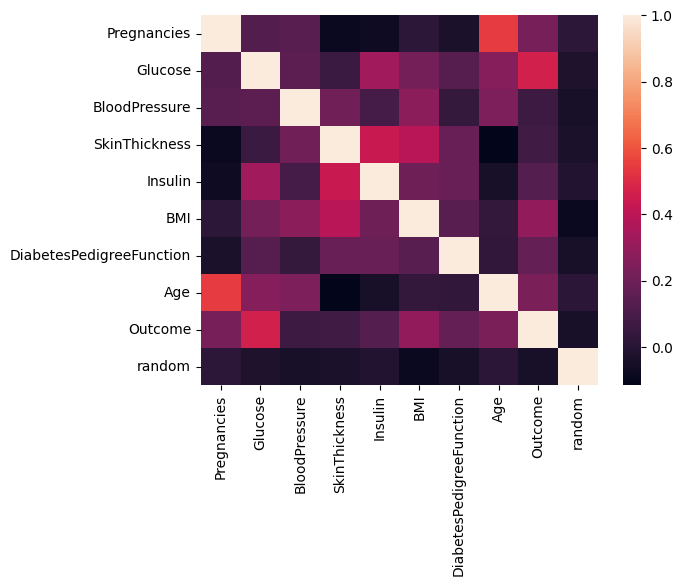

In [7]:
corr = numericData.corr()
sns.heatmap(corr)
plt.show()

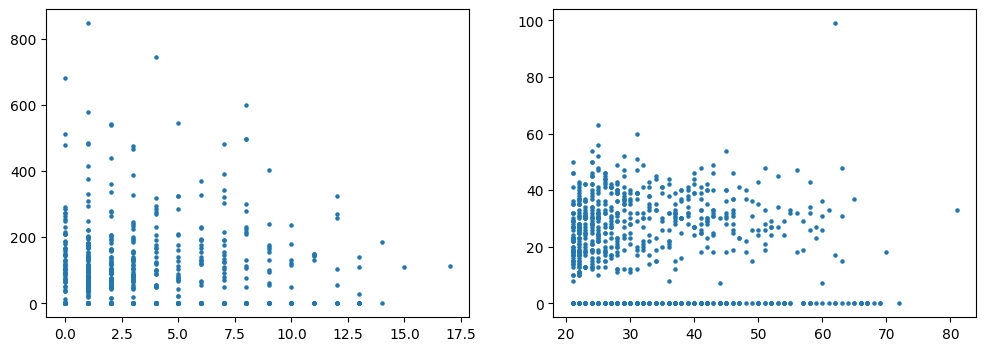

In [8]:
# Negative correlation 
least_correlated_pair_1 = ('Pregnancies', 'Insulin')
least_correlated_pair_2 = ('Age', 'SkinThickness')

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].scatter(data[least_correlated_pair_1[0]], data[least_correlated_pair_1[1]], s = 5) 
ax[1].scatter(data[least_correlated_pair_2[0]], data[least_correlated_pair_2[1]], s = 5)
plt.show()

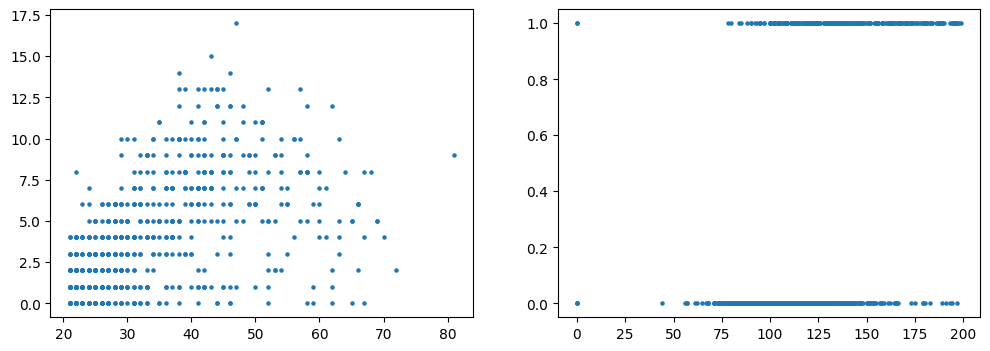

In [9]:
# Positive correlation
best_correlated_pair_1 = ('Age', 'Pregnancies')
best_correlated_pair_2 = ('Glucose', 'Outcome')

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].scatter(data[best_correlated_pair_1[0]], data[best_correlated_pair_1[1]], s = 5)
ax[1].scatter(data[best_correlated_pair_2[0]], data[best_correlated_pair_2[1]], s = 5)
plt.show()

Важность признаков

In [28]:
# 1 качество предсказания целевого признака по одному признаку f
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

res = []
for feature in numericData.drop([label], axis=1).columns:
    clf = ExtraTreesRegressor(n_estimators=100, random_state=0)
    X = np.array(numericData[feature]).reshape(-1, 1)
 
    pred = cross_val_predict(clf, X, numericData[label])
    res.append(abs(r2_score(numericData[label], pred)))

In [29]:
# 2 ExtraTrees
clf.fit(X = numericData.drop([label], axis=1), y = numericData[label])

ExtraTreesRegressor(random_state=0)

In [12]:
# 3 коэффициент линейной модели
from sklearn.linear_model import LinearRegression

def normalizeDF(df):
    res = df.copy()
    return (res-res.min())/(res.max()-res.min())

normData = normalizeDF(numericData)
lin = LinearRegression().fit(X = normData.drop([label], axis=1), y = normData[label])

In [30]:
# 4 Модуль коэффициента корреляции с целевым признаком
corr = [i for i in abs(numericData.corr()[label].drop([label]))]
corr

[0.5443412284023392,
 0.26351431982433343,
 0.23952794642136344,
 0.11397026236774152,
 0.04216295473537695,
 0.03624187009229395,
 0.03356131243480539,
 0.23835598302719757,
 0.015422203564695027]

In [14]:
# 5 Количество взаимной информации в f и целевом признаке
features = [c for c in numericData.columns if c != label and data.dtypes[c] != 'object']
X = data.loc[:,features]
y = data[label]

# Drop rows with missing values
X_dropped = X.dropna()
y_dropped = y.loc[X_dropped.index]

mi = abs(sklearn.feature_selection.mutual_info_regression(X_dropped, y_dropped))

Подходы к определению важности признака f:

    качество предсказания целевого признака по одному признаку f

    Свойство feature_importances_ модели ExtraTrees

    Модуль коэффициента линейной модели (признаки должны быть нормированными!)

    Модуль коэффициента корреляции с целевым признаком

    Количество взаимной информации в f и целевом признаке (используйте mutual_info_regression для задачи регрессии и mutual_info_classif для задачи классификации)


In [15]:
importance = pd.DataFrame()
importance['quality'] = res
importance['ExtraTrees'] = abs(clf.feature_importances_)
importance['linear'] = abs(lin.coef_)
importance['corr'] = corr
importance['MI'] = mi
importance = normalizeDF(importance)
importance.insert(0, 'name', features)

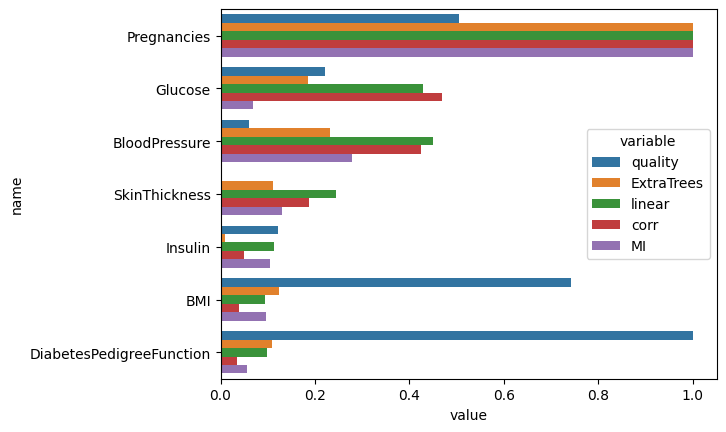

In [16]:
importance1 = importance[:7:]
importance2 = importance[7::]

importance1 = importance1.melt(id_vars=['name'], value_vars=['quality', 'ExtraTrees', 'linear', 'corr', 'MI'])
importance2 = importance2.melt(id_vars=['name'], value_vars=['quality', 'ExtraTrees', 'linear', 'corr', 'MI'])

sns.barplot(x='value', y='name', hue='variable', data=importance1)
plt.show()

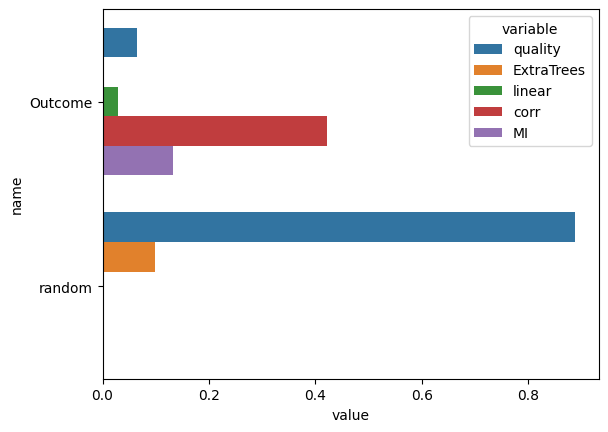

In [17]:
sns.barplot(x='value', y='name', hue='variable', data=importance2)
plt.show()

## Главные компоненты

1) Примените метод главных компонент к нормированной матрице объектов-признаков (sklearn.decomposition.PCA). Спроектируйте датасет на две главные компоненты (fit_transform) и постройте в плоскости этих компонент график рассеяния датасета, используя в качестве цвета значения целевого признака.  

2) Выведите координаты главной компоненты и соответсвующие им названия признаков (свойство components_). Анализируя вывод, выясните какие признаки меняются "в унисон" и соответствует ли это матрице корреляций. 

3) Примените PCA в качестве генеративной модели. Эффектнее всего такая генерация выглядит для датасета с изображениями, но мы попробуем применить аналогичную операцию и для наших данных. Для этого на графике рассеяния выберите какие-нибудь два набора значений главных компонент в областях разных классов (разных значений целевого признака - для регрессии). Причем выберите так, чтобы этим значениям не соответствовала никакая точка из обучающей выборки. После этого примените обратную трансформацию и найдите признаки, соответсвующие этим двум наборам. Запишите в отчете эти два набора в таблицу вместе с 10 другими случайными объектами. Насколько эти два искусственно построенных объекта реальны? Сможете ли вы отличить реальные объекты от искусственно сгенерированных?

4) Найдите две главные компоненты методом PLS (sklearn.cross_decomposition.PLSRegression, StandardScaler использовать не нужно - он уже встроен в PLSRegression). Нарисуйте аналогичный п.1 график рассеяния и поместите оба графика в отчете рядом друг с другом

# 1

In [18]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components = 2)
pca.fit(numericData)
pca_transformer = make_pipeline(StandardScaler(), pca)
pca_features = pca_transformer.fit_transform(numericData)

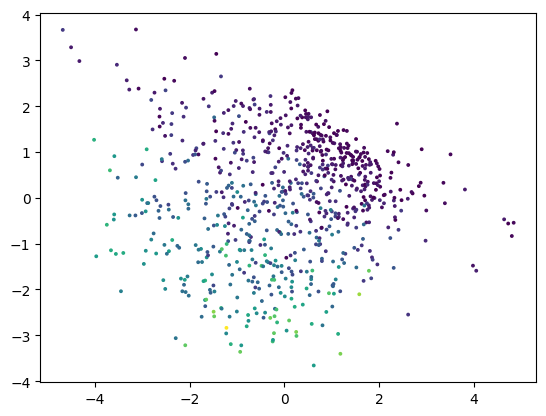

In [19]:
plt.scatter(pca_features[:,0], pca_features[:,1], c=numericData[label], s=3)
plt.show()

# 2

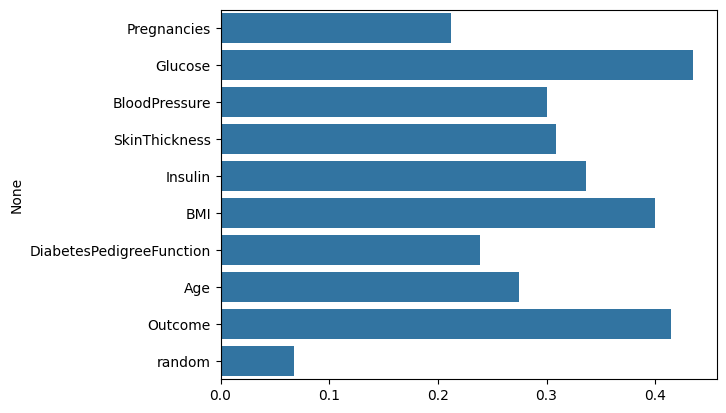

In [20]:
sns.barplot(x=abs(pca.components_[0]), y=numericData.columns)
plt.show()

# 3

In [21]:
new_pca_features = [[0, 0], [4, 2]]

In [22]:
og = pca_transformer.inverse_transform(new_pca_features)

In [23]:
import pandas as pd

randomDf = numericData.sample(n=10)

new_rows = [pd.DataFrame([og[0]], columns=randomDf.columns),
            pd.DataFrame([og[1]], columns=randomDf.columns)]

randomDf = pd.concat([randomDf] + new_rows, ignore_index=True)

randomDf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,random
0,3.000000,84.000000,72.000000,32.000000,0.000000,37.200000,0.267000,28.000000,0.000000,0.411322
1,8.000000,120.000000,0.000000,0.000000,0.000000,30.000000,0.183000,38.000000,1.000000,0.300678
2,6.000000,91.000000,0.000000,0.000000,0.000000,29.800000,0.501000,31.000000,0.000000,0.454781
3,6.000000,0.000000,68.000000,41.000000,0.000000,39.000000,0.727000,41.000000,1.000000,0.051325
4,3.000000,74.000000,68.000000,28.000000,45.000000,29.700000,0.293000,23.000000,0.000000,0.515221
5,2.000000,68.000000,62.000000,13.000000,15.000000,20.100000,0.257000,23.000000,0.000000,0.936368
6,7.000000,152.000000,88.000000,44.000000,0.000000,50.000000,0.337000,36.000000,1.000000,0.018338
7,8.000000,197.000000,74.000000,0.000000,0.000000,25.900000,1.191000,39.000000,1.000000,0.908376
8,1.000000,114.000000,66.000000,36.000000,200.000000,38.100000,0.289000,21.000000,0.000000,0.769523
9,2.000000,130.000000,96.000000,0.000000,0.000000,22.600000,0.268000,21.000000,0.000000,0.060716


# 4

In [24]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=2)
pls.fit(numericData.drop([label], axis=1), numericData[label])

PLSRegression()

In [25]:
pls_transformer = make_pipeline(pls)
pls_features = pls_transformer.fit_transform(numericData.drop([label], axis=1), numericData[label])

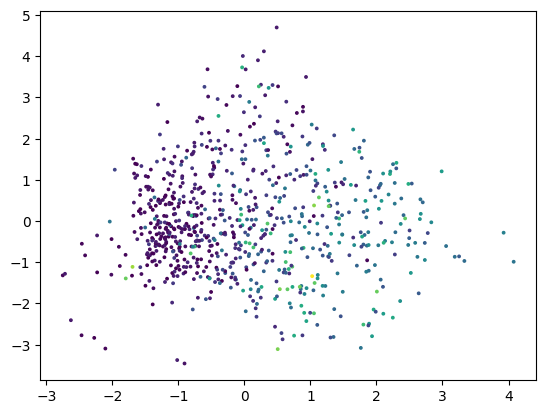

In [26]:
plt.scatter(pls_features[0][:,0], pls_features[0][:,1], c=numericData[label], s=3)
plt.show()